In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IS_KAGGLE = False

IS_SCALLER_ON = True

In [3]:
if IS_KAGGLE:
    #Kaggle
    train_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv")
    test_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")
else:
    train_df = pd.read_csv("datasets/ventilation/train.csv")
    test_df = pd.read_csv("datasets/ventilation/test.csv")

R distribution and C
Lung attribute indicating how restricted the airway is

C - lung attribute indicating how compliant the lung is (in mL/cmH2O).
Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.


                         Normal lungs	ARDS
    Compliance (ml/cmH2O)	50–60	35–45
    Resistance (cmH2O/(l/s))	10–15	10–15
    Expiratory time constant (s)	0.5–0.7	0.4–0.6



### Sort Training and Test set by breath id and id

In [4]:
sorted_train_df = train_df.sort_values(by=["id","breath_id"])
sorted_test_df = test_df.sort_values(by=["id","breath_id"])

In [5]:
sorted_train_df.u_out.unique()

array([0, 1])

## Based on https://www.hamilton-medical.com/en_US/News/Newsletter-articles/Article~2018-04-25~Bedside-tip%3A-How-to-use-the-expiratory-time-constant~a90bbb8e-6848-4854-ad6f-2f8e86e16f81~.html

RC is decaying exponentially

In [6]:
R_train = sorted_train_df.pop("R")
C_train = sorted_train_df.pop("C")
time_step_train = sorted_train_df.pop("time_step")

R_test = sorted_test_df.pop("R")
C_test = sorted_test_df.pop("C")
time_step_test = sorted_test_df.pop("time_step")

In [7]:
R_C_train = (R_train*C_train)
R_C_test= (R_test*C_test)

In [8]:
R_C_exp_decay_train = (1/R_C_train)*np.exp(-(time_step_train-3))
R_C_exp_decay_test = (1/R_C_test)*np.exp(-(time_step_test-3))

In [9]:
sorted_train_df['R_C_exp'] = R_C_exp_decay_train
sorted_test_df['R_C_exp'] = R_C_exp_decay_test

<AxesSubplot: >

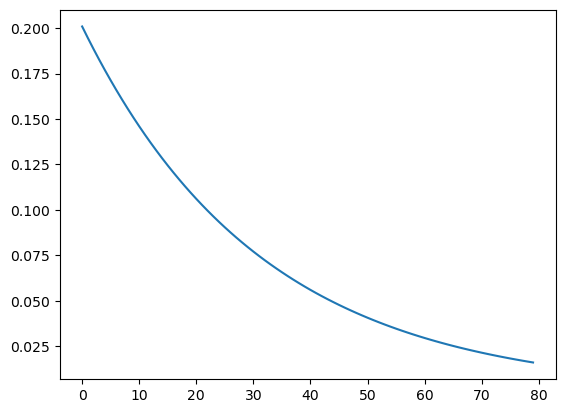

In [10]:
sorted_test_df.query("breath_id==0")["R_C_exp"].plot()

<AxesSubplot: >

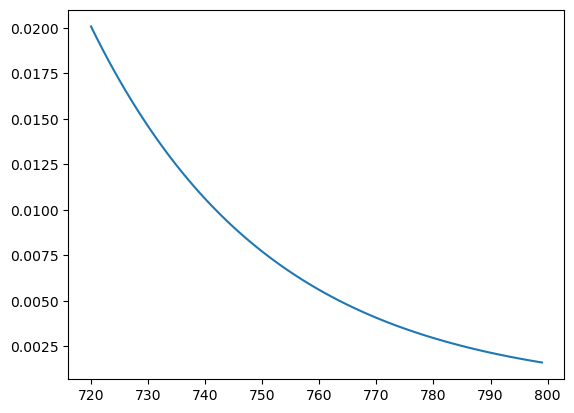

In [11]:
sorted_train_df.query("breath_id==12")["R_C_exp"].plot()

## Express u_in as a vector

In [12]:
u_in_train = sorted_train_df.pop('u_in')
u_in_test = sorted_test_df.pop('u_in')

### Train

In [13]:
#over 3 time steps

sin_u_in_train = u_in_train*np.sin(2*np.pi*(u_in_train/3))

cos_u_in_train = u_in_train*np.cos(2*np.pi*(u_in_train/3))

sorted_train_df['sin_u_in'] = sin_u_in_train

sorted_train_df['cos_u_in'] = cos_u_in_train

sorted_train_df['u_in'] = sin_u_in_train + cos_u_in_train

### Test

In [14]:
sin_u_in_test = u_in_test*np.sin(2*np.pi*(u_in_test/240))

cos_u_in_test = u_in_test*np.cos(2*np.pi*(u_in_test/240))

sorted_test_df['sin_u_in'] = sin_u_in_test

sorted_test_df['cos_u_in'] = cos_u_in_test

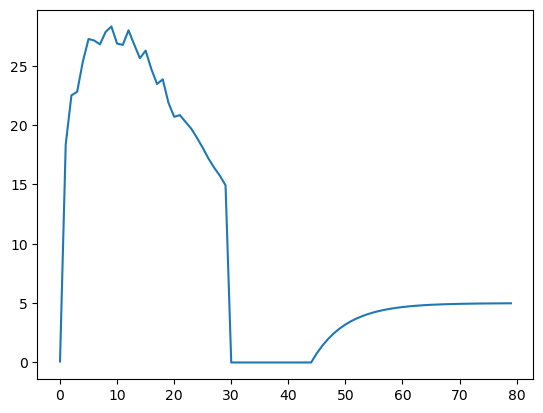

In [15]:
plt.plot(u_in_train[:80])

<AxesSubplot: >

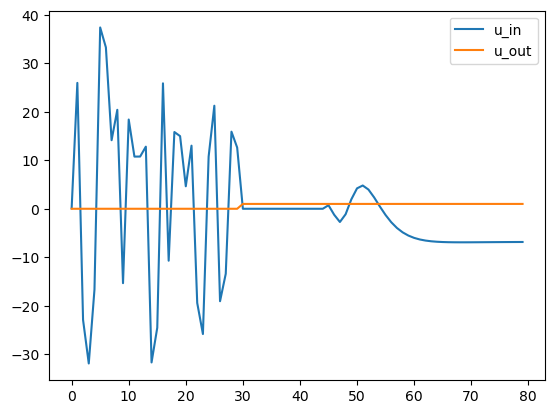

In [16]:
sorted_train_df.query("breath_id==1")[['u_in', 'u_out']].plot()

<AxesSubplot: >

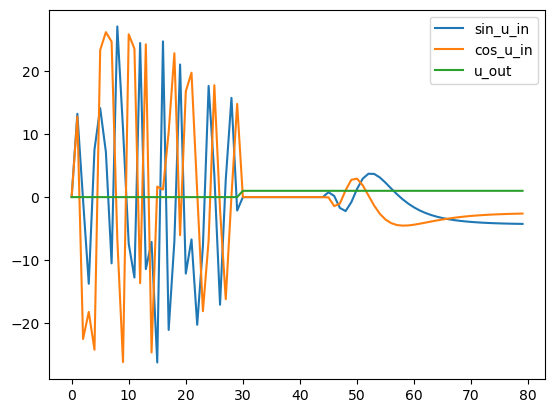

In [17]:
sorted_train_df.query("breath_id==1")[['sin_u_in', 'cos_u_in', 'u_out']].plot()

<AxesSubplot: >

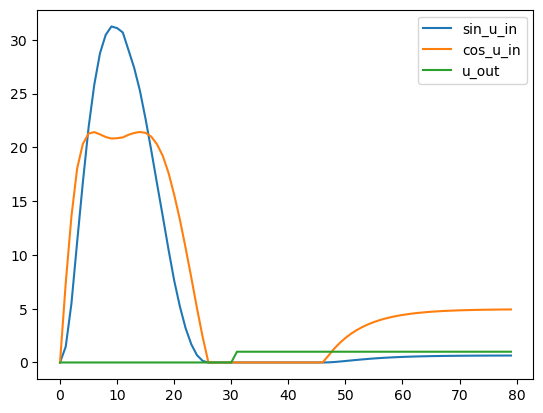

In [18]:
sorted_test_df.query("breath_id==0")[['sin_u_in', 'cos_u_in', 'u_out']].plot()

### time steps

### Train

In [19]:
sin_time_step_train = np.sin(2*np.pi*(time_step_train/3))

cos_time_step_train = np.cos(2*np.pi*(time_step_train/3))

sorted_train_df['sin_time_step'] = sin_time_step_train

sorted_train_df['cos_time_step'] = cos_time_step_train

### Test

In [20]:
#time_step

sin_time_step_test = np.sin(2*np.pi*(time_step_test/3))

cos_time_step_test = np.cos(2*np.pi*(time_step_test/3))

sorted_test_df['sin_time_step'] = sin_time_step_test

sorted_test_df['cos_time_step'] = cos_time_step_test

<AxesSubplot: >

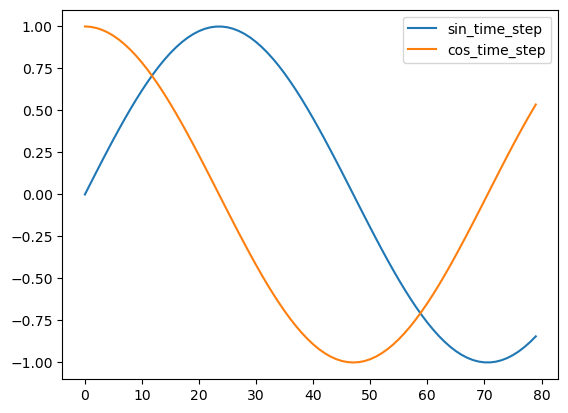

In [21]:
sorted_test_df.query("breath_id==0")[['sin_time_step', 'cos_time_step']].plot()

<AxesSubplot: >

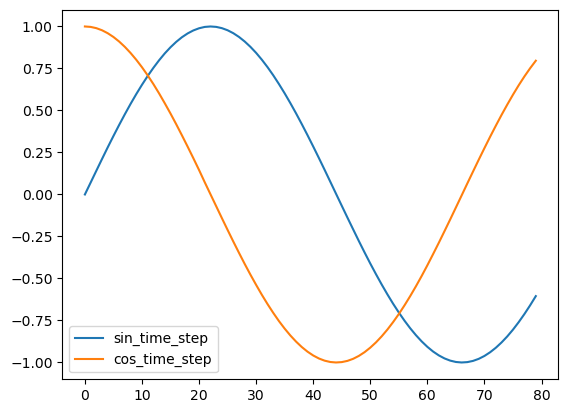

In [22]:
sorted_train_df.query("breath_id==1")[['sin_time_step', 'cos_time_step']].plot()

In [23]:
target = ['pressure']

features = ['R_C_exp', 'sin_u_in', 'cos_u_in', 'u_out', 'sin_time_step', 'cos_time_step']

Each secuence has 80 points or timesteps

Dataset has 1 row per timestep 

the first 80 rows belong to the first series. My window lenght is 80 and the stride is 80 with 4 features.

## Test and Train datasets

In [24]:
X_train = sorted_train_df[features].to_numpy()
y_train = sorted_train_df[target].to_numpy()
X_test = sorted_test_df[features].to_numpy()

## Scale atributes

In [25]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

### Inspect one breath secuence after scaling atributes

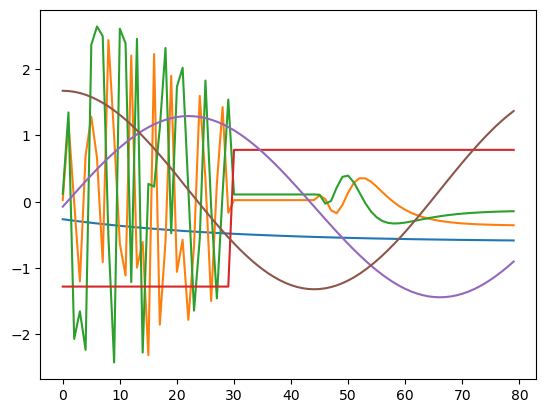

In [26]:
plt.plot(X_train[:80])

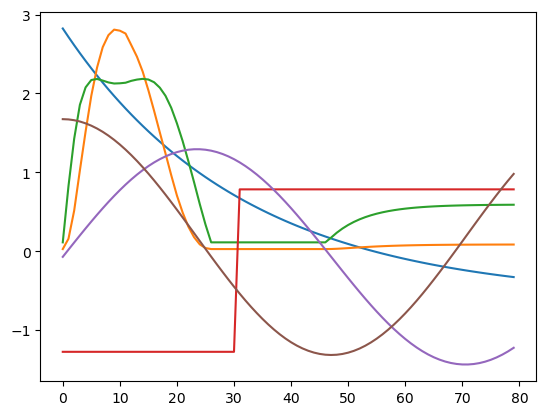

In [27]:
plt.plot(X_test[:80])

## Models

In [28]:
feature_lenght = len(features)

In [29]:
def build_windows(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True
    
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.map(lambda window: (window[:, :feature_lenght], window[:, feature_lenght:]))
    dataset = dataset.batch(512).shuffle(16).prefetch(128)
    return dataset

def build_windows_predict(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True

    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.batch(512).prefetch(32)

    return dataset

In [30]:
test_dataset = build_windows_predict(X_test)
dataset_train = build_windows(np.concatenate([X_train, y_train], axis=1))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-24 19:18:40.918118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-24 19:18:40.918245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
X_input = tf.keras.layers.Input(shape=(80, feature_lenght))

X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(40, return_sequences=True))(X_input)
X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(40, return_sequences=True))(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(40))(X)

X = tf.keras.layers.Dense(256, activation='swish')(X)
X = tf.keras.layers.Dropout(0.5)(X)

X_output = tf.keras.layers.Dense(80, activation='swish')(X)

lstm_model = tf.keras.Model(inputs=X_input, outputs=X_output)

In [32]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer="Adam",
            metrics=[tf.keras.metrics.MeanSquaredError()])

In [33]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 80)           11520     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 80)           29280     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80)               29280     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               20736     
                                                             

In [34]:
lstm_model.fit(dataset_train, epochs=50, shuffle=True, use_multiprocessing=True)

Epoch 1/50


2023-01-24 19:18:44.435873: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-24 19:18:44.450240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:18:46.240687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:18:46.252941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:18:47.102943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:18:47.116516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:18:47.432553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

148/148 [==============================] - 38s 199ms/step - loss: 54.8096 - mean_squared_error: 54.8096
Epoch 2/50
148/148 [==============================] - 28s 182ms/step - loss: 19.8608 - mean_squared_error: 19.8608
Epoch 3/50
148/148 [==============================] - 29s 191ms/step - loss: 16.5323 - mean_squared_error: 16.5323
Epoch 4/50
148/148 [==============================] - 29s 189ms/step - loss: 14.7607 - mean_squared_error: 14.7607
Epoch 5/50
148/148 [==============================] - 30s 193ms/step - loss: 13.5893 - mean_squared_error: 13.5893
Epoch 6/50
148/148 [==============================] - 30s 196ms/step - loss: 12.3375 - mean_squared_error: 12.3375
Epoch 7/50
148/148 [==============================] - 29s 188ms/step - loss: 11.9301 - mean_squared_error: 11.9301
Epoch 8/50
148/148 [==============================] - 32s 210ms/step - loss: 13.4791 - mean_squared_error: 13.4791
Epoch 9/50
148/148 [==============================] - 56s 372ms/step - loss: 11.1495 - mean

In [35]:
predictions = lstm_model.predict(test_dataset, verbose=1)

2023-01-24 19:52:36.366776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:36.672941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:36.672965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:37.024482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:37.035007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:37.357671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 19:52:37.367529: I tensorflow/core/grappler/optimizers/cust

99/99 [==============================] - 11s 91ms/step


In [36]:
predictions_df = pd.DataFrame(zip(test_df.sort_values(['id', 'breath_id', 'time_step'],ascending=True).id.to_numpy(),
                                                        predictions.flatten()),
                                                        columns=['id', 'pressure']
                             )

In [37]:
predictions_df.to_csv("submission.csv", index=False)